<a href="https://colab.research.google.com/github/sahin-arslan/Bank-Loan-Prediction-using-AI/blob/main/OgrenciBasariTahminleme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython import get_ipython
from IPython.display import display

!pip install optuna
import optuna # Changed to lowercase 'o'
from sklearn.ensemble import RandomForestRegressor # Changed to Regressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error # Changed metric for regression

# 1. Veri setini yükleme ve hazırlama
import pandas as pd
data = pd.read_csv("StudentDataSets.csv")  # Veri setinizi buraya yükleyin

# Hedef değişken ve özellikleri belirleyin
X = data.drop(columns=["GPA"])  # Hedef sütun hariç tüm sütunlar
y = data["GPA"]  # Hedef sütun

# Eğer kategorik veriler varsa, dummies ile dönüştürün
X = pd.get_dummies(X, drop_first=True)

# Eğitim ve test seti oluşturma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [2]:
# 2. Hiperparametre optimizasyonu için bir hedef fonksiyonu tanımlayın
def objective(trial):
    # Optuna'nın optimize etmesi için hiperparametreler
    n_estimators = trial.suggest_int("n_estimators", 10, 200)  # Ağaç sayısı
    max_depth = trial.suggest_int("max_depth", 2, 32)  # Ağaç derinliği
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)  # Minimum dal bölme
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)  # Minimum yaprak boyutu

    # Random Forest modeli - Changed to Regressor for continuous target
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Çapraz doğrulama ile model performansını değerlendirin - Using negative MSE for maximization
    score = -cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error").mean()
    return score



In [3]:
# 3. Optuna çalıştırarak en iyi parametreleri bulma
study = optuna.create_study(direction="maximize")  # Accuracy'yi maksimize etmeye çalışıyoruz
study.optimize(objective, n_trials=100)  # Belirtilen sayıda deneme yapılacak (50 kez)

# En iyi hiperparametreleri alma
best_params = study.best_params
print("En iyi hiperparametreler:", best_params)


[I 2025-01-16 17:38:55,191] A new study created in memory with name: no-name-f897905c-fa41-45c4-a425-c751eb521294
[I 2025-01-16 17:39:21,144] Trial 0 finished with value: 0.6464507020038924 and parameters: {'n_estimators': 117, 'max_depth': 22, 'min_samples_split': 19, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6464507020038924.
[I 2025-01-16 17:39:26,221] Trial 1 finished with value: 0.6377288224650715 and parameters: {'n_estimators': 49, 'max_depth': 10, 'min_samples_split': 18, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6464507020038924.
[I 2025-01-16 17:39:37,671] Trial 2 finished with value: 0.6423196154669741 and parameters: {'n_estimators': 105, 'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.6464507020038924.
[I 2025-01-16 17:40:02,884] Trial 3 finished with value: 0.6415774168553801 and parameters: {'n_estimators': 183, 'max_depth': 24, 'min_samples_split': 20, 'min_samples_leaf': 17}. Best is trial 0 with 

En iyi hiperparametreler: {'n_estimators': 10, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 10}


In [4]:
# 4. En iyi parametrelerle modeli yeniden eğitme - Changed to Regressor
final_model = RandomForestRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, min_samples_leaf=10, min_samples_split=7,
                      n_estimators=10, random_state=42)

In [5]:
# 5. Modeli test seti üzerinde değerlendirme - Changed metric to MSE
y_pred = final_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test seti ortalama kare hatası:", mse)

Test seti ortalama kare hatası: 0.6529718593097226


##. Gerçek ve Tahmin Edilen Değerlerin Karşılaştırılması (Scatter Plot)

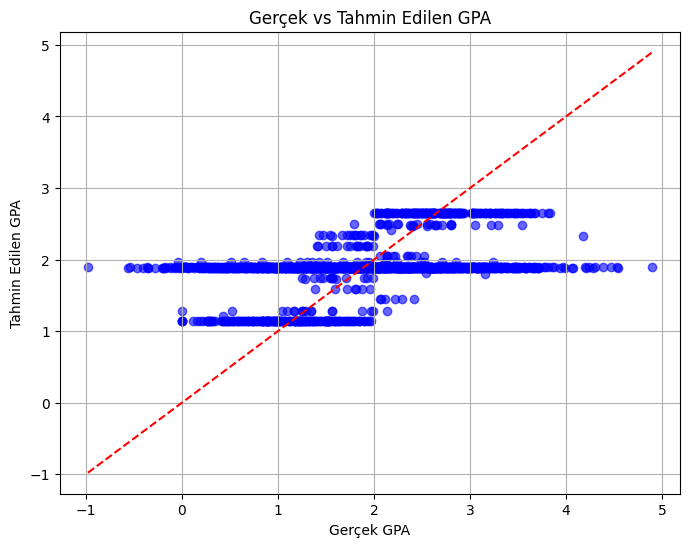

In [6]:
import matplotlib.pyplot as plt

# Gerçek ve tahmin edilen değerleri karşılaştıran scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Gerçek vs Tahmin Edilen GPA")
plt.xlabel("Gerçek GPA")
plt.ylabel("Tahmin Edilen GPA")
plt.grid(True)
plt.show()


## 2. Hataların Dağılımı (Residual Plot)

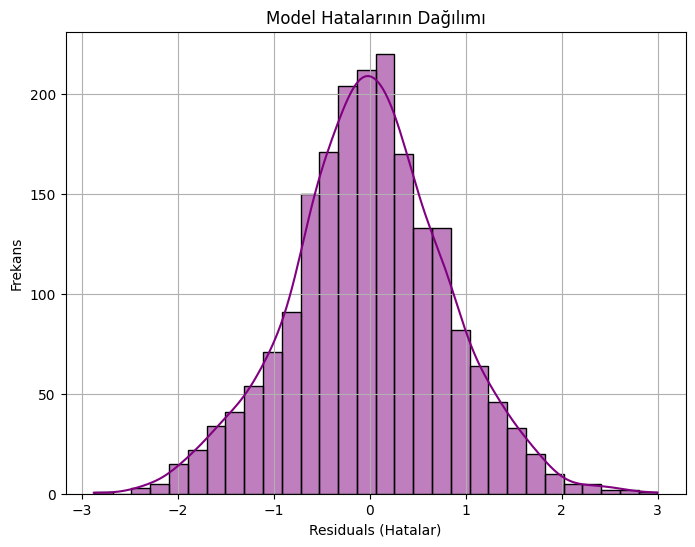

In [7]:
import seaborn as sns

# Modelin hataları
residuals = y_test - y_pred

# Hataların dağılımını gösteren histogram
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.title("Model Hatalarının Dağılımı")
plt.xlabel("Residuals (Hatalar)")
plt.ylabel("Frekans")
plt.grid(True)
plt.show()
